# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [36]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [110]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    print('train_x.mean',mean_image[0])
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    #print('train_flat_ones.shape', train_flat_with_ones.shape)
    #print('train_flat_ones[0]', train_flat_with_ones[0])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000) 
print('train_X.shape initial', train_X.shape) #expect 1000,32,32,3
#print('train_X[0,0]', train_X[0,0])
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

('train_X.shape initial', (10000, 32, 32, 3))
('train_x.mean', 0.446616470588233)
('indices initial', array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
('indices after shuffle', array([6252, 4684, 1731, 4742, 4521, 6340,  576, 5202, 6363,  439]))


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [39]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))


('it.shape=', (1,))
Gradient check passed!


True

In [40]:
def array_sum(x):
    #print('x.shape',x.shape)
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

('it.shape=', (2,))
Gradient check passed!


True

In [41]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

('it.shape=', (1,))
Gradient check passed!
('it.shape=', (2,))
Gradient check passed!
('it.shape=', (2, 2))
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [42]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
probs = linear_classifer.softmax(np.array([1, 1, 1]))
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0][0], 1.0)

In [43]:
a=np.zeros(5)
print(a)
print(np.ndim(a))
b=a.reshape(1,-1)
print(b)

[0. 0. 0. 0. 0.]
1
[[0. 0. 0. 0. 0.]]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [44]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
print('probs',probs)
#linear_classifer.cross_entropy_loss(probs, 1)
loss=linear_classifer.cross_entropy_loss(probs, np.array([[1]]))
print('loss=',loss)

('probs', array([[0.57611688, 0.21194156, 0.21194156]]))
('loss=', array([1.55144471]))


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [45]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient, check_gradient_batch
from metrics import multiclass_accuracy 
import linear_classifer

# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print('loss=',loss)
print('grad',grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

print('----------star check batch------')
predictions=np.array([[1,0,0],[1,0,0]],dtype=np.float)
target_index=np.array([[1],[0]],dtype=np.int)
loss, grad =linear_classifer.softmax_with_cross_entropy_batch(predictions, target_index)
print('loss=',loss)
print('grad',grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy_batch(x, target_index), predictions)
#check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy_batch(x, np.array([1,0]), np.array([[1,0,0],[1,0,0]],np.float))

('loss=', 1.551444713932051)
('grad', array([ 0.57611688, -0.78805844,  0.21194156]))
('it.shape=', (3,))
Gradient check passed!
----------star check batch------
('loss=', 1.051444713932051)
('grad', array([[ 0.28805844, -0.39402922,  0.10597078],
       [-0.21194156,  0.10597078,  0.10597078]]))
('it.shape=', (2, 3))
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [46]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1

print('----------- batch 2, num 4 ----------')
num_classes = 4
batch_size = 2
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy_batch(x, target_index), predictions)

# Test batch_size = 3
print('----------- batch 3, num 4 ----------')
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy_batch(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))


----------- batch 2, num 4 ----------
('predictions', array([[ 1.,  2., -1.,  1.],
       [ 1.,  2., -1., -1.]]))
('it.shape=', (2, 4))
Gradient check passed!
----------- batch 3, num 4 ----------
('it.shape=', (3, 4))
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [47]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 4
num_features = 3

num_classes = 2
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
print('loss',loss)
print('dW=',dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

('loss', 0.5472365148987376)
('dW=', array([[-0.22019927,  0.22019927],
       [-0.20332316,  0.20332316],
       [ 0.23874859, -0.23874859]]))
('it.shape=', (3, 2))
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [48]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

('it.shape=', (3, 2))
Gradient check passed!


True

In [87]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient, check_gradient_batch
from metrics import multiclass_accuracy 
import linear_classifer

# this is my test
batch_size = 5
num_features = 3

num_classes = 2
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)
print('target_index',target_index)

loss_sm, dW_sm = linear_classifer.linear_softmax(X, W, target_index)
print('loss SoftMax',loss_sm)
print('dW Softmax=',dW_sm)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)
loss_l2, dW_l2=linear_classifer.l2_regularization(W, 0.01)
print('loss L2',loss_l2)
print('dW  L2=',dW_l2)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

loss,dW=linear_classifer.linear_softmax_l2(W, 0.01, X, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax_l2(w, 0.01,X,target_index), W)

('target_index', array([1, 1, 1, 1, 1]))
('loss SoftMax', 0.44141919750255204)
('dW Softmax=', array([[-0.16896493,  0.16896493],
       [-0.15906129,  0.15906129],
       [ 0.19099887, -0.19099887]]))
('it.shape=', (3, 2))
Gradient check passed!
('loss L2', 0.12)
('dW  L2=', array([[ 0.02,  0.04],
       [-0.02,  0.02],
       [ 0.02,  0.04]]))
('it.shape=', (3, 2))
Gradient check passed!
('it.shape=', (3, 2))
Gradient check passed!


True

In [105]:
classifier = linear_classifer.LinearSoftmaxClassifier()

num_train=train_X.shape[0]
num_features = train_X.shape[1]
num_classes = np.max(train_y)+1
batch_size=20
reg=1e1
learning_rate=1e-3
print('num_train', num_train)
print('num_features', num_features)
print('num_classe',num_classes)
print('batch_size',batch_size)
W = 0.001 * np.random.randn(num_features, num_classes)
sections = np.arange(batch_size, num_train, batch_size)
print('sections',sections)
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
print('shuffled indices [0:10]', shuffled_indices[0:10])
batches_indices = np.array_split(shuffled_indices, sections)
print('batches_indices', len(batches_indices))
print('batches_indices[0].shape', batches_indices[0].shape)

target_index=train_y[batches_indices[0]]
X=train_X[batches_indices[0]]
loss,dW=linear_classifer.linear_softmax_l2(W, reg, X, target_index)
print('loss',loss)
check_gradient(lambda w: linear_classifer.linear_softmax_l2(w, reg,X,target_index), W)
#loss_history = classifier.fit(train_X, train_y, epochs=1, learning_rate=1e-3, batch_size=1, reg=1e1)

('num_train', 900)
('num_features', 3073)
('num_classe', 10)
('batch_size', 20)
('sections', array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260,
       280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520,
       540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780,
       800, 820, 840, 860, 880]))
('shuffled indices [0:10]', array([722, 826, 642, 368,  46, 492, 303, 314, 388,  10]))
('batches_indices', 45)
('batches_indices[0].shape', (20,))
('loss', 2.605083910175978)
('it.shape=', (3073, 10))
Gradient check passed!


True

In [104]:
t=np.arange(10)*2
i=np.array([1,3,5])
print(t)
print(i)
print(t[i])
print(batches_indices[0])
print(train_y[batches_indices[0]])

[ 0  2  4  6  8 10 12 14 16 18]
[1 3 5]
[ 2  6 10]
[853 402  76  22 568 763 452 838 542 331  55 187 616  47 181 861 670  66
 803 716]
[5 9 1 4 0 3 0 0 2 7 2 6 1 5 5 3 2 2 2 3]


# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [117]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.398027
Epoch 1, loss: 2.331343
Epoch 2, loss: 2.310226
Epoch 3, loss: 2.304392
Epoch 4, loss: 2.303214
Epoch 5, loss: 2.301560
Epoch 6, loss: 2.302410
Epoch 7, loss: 2.301187
Epoch 8, loss: 2.302606
Epoch 9, loss: 2.301999


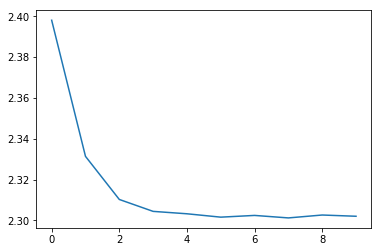

In [118]:
# let's look at the loss history!
plt.plot(loss_history)

In [132]:
print('val_X.shape',val_X.shape)
pred = classifier.predict(val_X)
print('val_X[10]',val_y[:10])
print('pred[10]', pred[:10])
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

('val_{.shape', (1000, 3073))
('val_X[10]', array([2, 9, 8, 4, 6, 5, 3, 3, 3, 1], dtype=uint8))
('pred[10]', array([2, 4, 4, 3, 5, 7, 5, 1, 2, 5]))
('Accuracy: ', 0.131)


In [133]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

('Accuracy: ', 0.131)
Epoch 0, loss: 2.302099
Epoch 1, loss: 2.301690
Epoch 2, loss: 2.302466
Epoch 3, loss: 2.301759
Epoch 4, loss: 2.302840
Epoch 5, loss: 2.303159
Epoch 6, loss: 2.301671
Epoch 7, loss: 2.302135
Epoch 8, loss: 2.300488
Epoch 9, loss: 2.302301
Epoch 10, loss: 2.302734
Epoch 11, loss: 2.301382
Epoch 12, loss: 2.301458
Epoch 13, loss: 2.302540
Epoch 14, loss: 2.302328
Epoch 15, loss: 2.302900
Epoch 16, loss: 2.301686
Epoch 17, loss: 2.302472
Epoch 18, loss: 2.301554
Epoch 19, loss: 2.302166
Epoch 20, loss: 2.301233
Epoch 21, loss: 2.301720
Epoch 22, loss: 2.302043
Epoch 23, loss: 2.301621
Epoch 24, loss: 2.301974
Epoch 25, loss: 2.301781
Epoch 26, loss: 2.302076
Epoch 27, loss: 2.302434
Epoch 28, loss: 2.302546
Epoch 29, loss: 2.302168
Epoch 30, loss: 2.301965
Epoch 31, loss: 2.302220
Epoch 32, loss: 2.302411
Epoch 33, loss: 2.301733
Epoch 34, loss: 2.301143
Epoch 35, loss: 2.301641
Epoch 36, loss: 2.301730
Epoch 37, loss: 2.302544
Epoch 38, loss: 2.300763
Epoch 39, los

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))